# Laue diffraction peak identification

The dataset used has been recorded at ESRF ID09 in 2022 with an energy of 17keV andd 1.7% bandpass.
This is a small fragment of the experiment `ch6495` performed by Dominik Schaniel (univ-lorraine.fr) helped by Marco Cammarata (local contact)
The sample is a single crystal of iron complex (thus a small molecule).

Data files are available from: http://www.silx.org/pub/pyFAI/laue/

In [1]:
from silx.resources import ExternalResources
#Nota: Useful to configure a proxy if you are behind a firewall
#os.environ["http_proxy"] = "http://proxy.company.fr:3128"

downloader = ExternalResources("laue", "http://www.silx.org/pub/pyFAI/laue/")
poni = downloader.getfile("detx_50mm_2.poni")
maskfile = downloader.getfile("mask.npy")
datafile = downloader.getfile("SNP_220K_21/SNP_220K_21_0002/scan0001/rayonix_0018.h5")

In [2]:
import numpy
import pyFAI
import fabio
print(f"PyFAI version {pyFAI.version}")

PyFAI version 2023.9.0-dev0


In [3]:
%matplotlib inline
# use `widget` instead of `inline` for better user-exeperience. `inline` allows to store plots into notebooks.
from matplotlib.pyplot import subplots

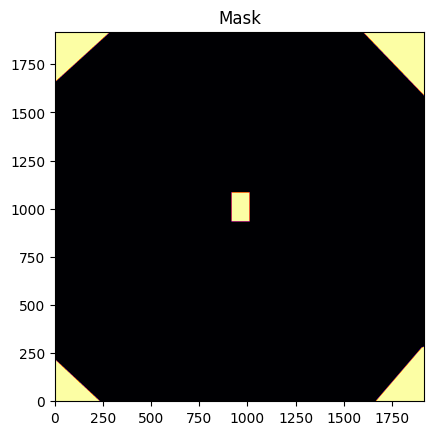

In [4]:
from pyFAI.gui import jupyter
mask = fabio.open(maskfile).data
jupyter.display(mask, label="Mask")
pass

<Axes: title={'center': 'Last frame'}>

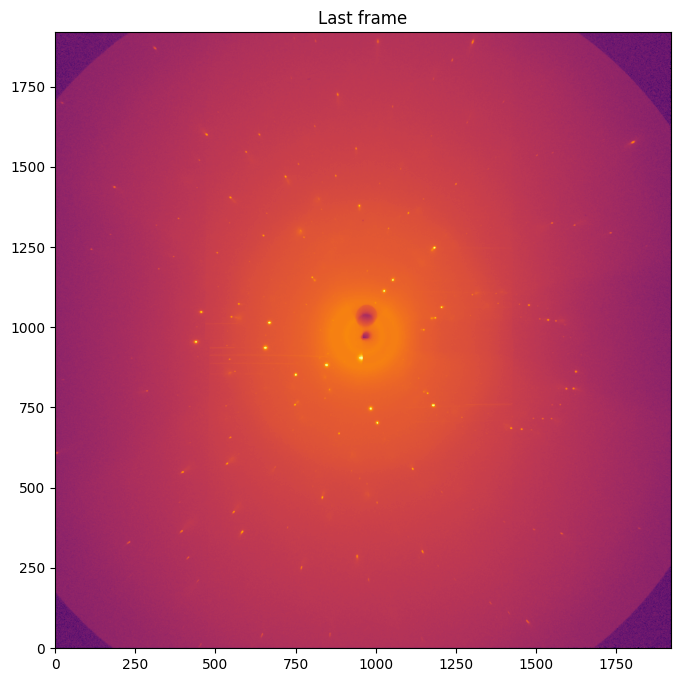

In [5]:
data = fabio.open(datafile).data
fig, ax = subplots(figsize=(8,8))
jupyter.display(data, label="Last frame", ax=ax)

## Generate an azimuthal integrator, integrate and look at the background:

In [6]:
npt = 512
error_model = "azimuth"
unit = "q_nm^-1"
ai = pyFAI.load(poni)
ai.detector.set_mask(mask)
print(ai)

/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


Detector Rayonix MX170	 PixelSize= 8.854e-05, 8.854e-05 m
Wavelength= 7.306081e-11 m
SampleDetDist= 4.928280e-02 m	PONI= 8.602623e-02, 8.526832e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 49.283 mm	Center: x=963.030, y=971.590 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 0.731Å


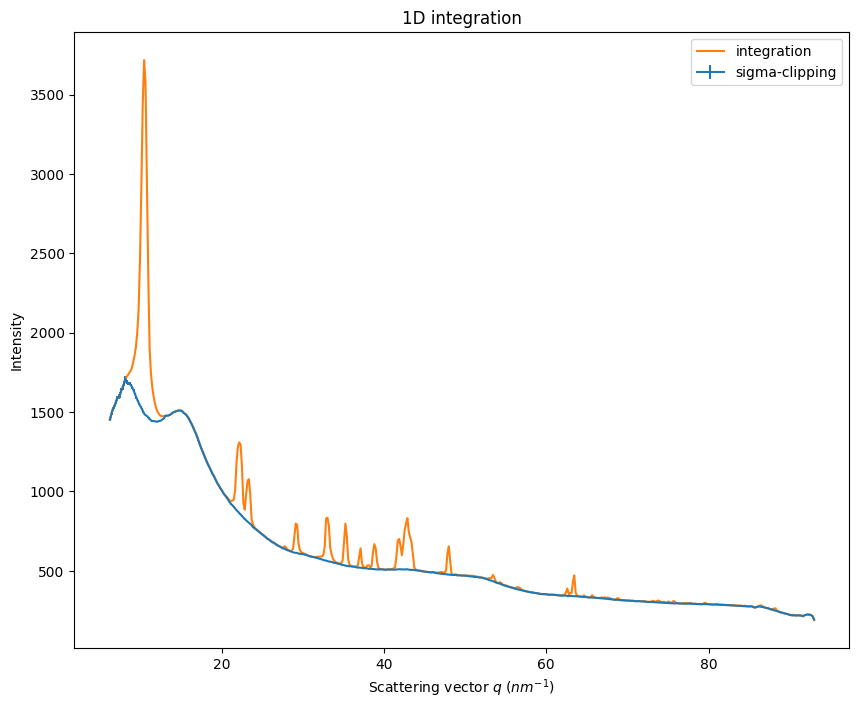

In [7]:
it = ai.integrate1d(data, npt, unit=unit)
sc = ai.sigma_clip_ng(data, npt, error_model=error_model, unit=unit)
fig, ax = subplots(figsize=(10,8))
jupyter.plot1d(sc, label="sigma-clipping", ax=ax)
jupyter.plot1d(it, label="integration", ax=ax)
pass

## Peak finding

This requires an OpenCL device, a GPU for best performances.

In [8]:
from pyFAI.opencl.peak_finder import OCL_PeakFinder

engine = ai.setup_sparse_integrator(data.shape, npt, mask, unit=unit, split="no")
radius2d = ai.array_from_unit(data.shape, unit=unit)
pf = OCL_PeakFinder(engine.lut, data.size, 
                   unit=unit, 
                   bin_centers=engine.bin_centers,
                   radius=radius2d,
                   mask = mask)

/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:417: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, [devices[i] for i in to_be_built_indices])


In [9]:
# The default parameters for the peakfinder are tuned for protein crystallography. Here peaks are much larger.
peaks = pf.peakfinder(data, error_model=error_model, patch_size=15, connected=15)
%timeit pf.peakfinder(data, error_model=error_model, patch_size=15, connected=15)
print(len(peaks))
peaks[:10]

19 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
132


array([(1167366,  7172.4106,  83.67626,  607.7821 ,   5.1015353),
       (2757305, 12326.779 , 184.56903, 1436.2598 , 184.94702  ),
       ( 633832,  9462.711 , 170.4739 ,  328.65286, 229.8383   ),
       (1538207,  3261.6282, 103.68616,  801.0311 , 286.42944  ),
       (3588792, 10536.642 ,  76.82227, 1869.264  , 311.29846  ),
       ( 701196, 27166.895 , 264.11288,  363.5771 , 394.54123  ),
       (1052559, 54561.06  , 318.79062,  547.92084, 397.61136  ),
       (2571265,  5767.143 , 186.48305, 1338.468  , 384.62204  ),
       ( 401725,  4898.5884, 227.50903,  208.83492, 444.75378  ),
       ( 543776, 10289.167 , 241.3157 ,  281.41272, 414.67313  )],
      dtype=[('index', '<i4'), ('intensity', '<f4'), ('sigma', '<f4'), ('pos0', '<f4'), ('pos1', '<f4')])

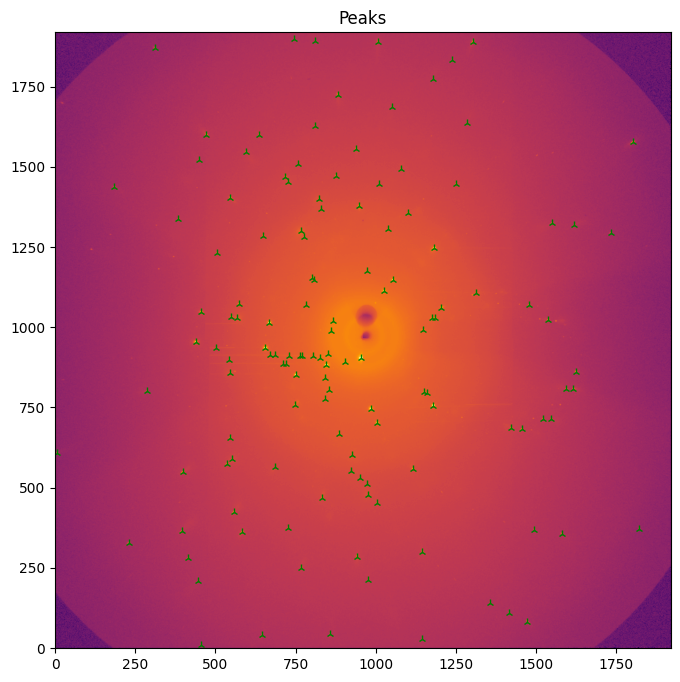

In [10]:
#overlay peaks with image
fig, ax = subplots(figsize=(8,8))
jupyter.display(data, label="Peaks", ax=ax)
ax.plot(peaks["pos1"],peaks["pos0"], "2g")
pass

## Conclusion

Peak position can easily be extracted for single crystal experiment at speed compatible with real-time data analysis.